In [64]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

Initial Data Preparation

In [65]:
columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']

In [66]:
df1 = pd.read_csv('adult.data',names=columns)
df2 = pd.read_csv('adult.test',names=columns)

In [67]:
df2.drop(0, inplace=True)
df2['age'] = df2['age'].astype('int64')

In [68]:
df = pd.concat([df1, df2])

In [69]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [70]:
df.shape

(48842, 15)

### Exploratory Data Analysis

In [71]:
df['income'].value_counts(normalize=True)

 <=50K     0.506122
 <=50K.    0.254596
 >50K      0.160538
 >50K.     0.078744
Name: income, dtype: float64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  int64  
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   education       48842 non-null  object 
 4   education-num   48842 non-null  float64
 5   marital-status  48842 non-null  object 
 6   occupation      48842 non-null  object 
 7   relationship    48842 non-null  object 
 8   race            48842 non-null  object 
 9   sex             48842 non-null  object 
 10  capital-gain    48842 non-null  float64
 11  capital-loss    48842 non-null  float64
 12  hours-per-week  48842 non-null  float64
 13  native-country  48842 non-null  object 
 14  income          48842 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 6.0+ MB


In [73]:
#No null Values

df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [74]:
categorical = list(df.columns[df.dtypes == "object"])
for c in categorical:
    print(c,df[c].nunique())
    print(df[c].unique())

workclass 9
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education 16
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
marital-status 7
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation 15
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relationship 6
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race 5
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex 2
[' Male' ' Female']
native-country 42
[' United-States' ' Cuba' ' 

In [75]:
#Transforming Target values from income to 0 if below or equal 50k and 1 if higher than 50k
df['income'] = df['income'].map({' <=50K':0,' <=50K.':0, ' >50K':1,' >50K.':1})

In [76]:
for c in categorical:
    print(c,df[c][df[c] == " ?"].value_counts())

workclass  ?    2799
Name: workclass, dtype: int64
education Series([], Name: education, dtype: int64)
marital-status Series([], Name: marital-status, dtype: int64)
occupation  ?    2809
Name: occupation, dtype: int64
relationship Series([], Name: relationship, dtype: int64)
race Series([], Name: race, dtype: int64)
sex Series([], Name: sex, dtype: int64)
native-country  ?    857
Name: native-country, dtype: int64
income Series([], Name: income, dtype: int64)


In [77]:
#Removing unknown records " ?" from the columns workclass, occupation
df.drop(df[df['workclass'] == " ?"].index, inplace=True)
df.drop(df[df['occupation'] == " ?"].index, inplace=True)
df.drop(df[df['native-country'] == " ?"].index, inplace=True)

In [78]:
df['native-country'][df['native-country'] == " ?"]

Series([], Name: native-country, dtype: object)

In [79]:
df.shape

(42996, 15)

In [80]:
#Checking for Duplicate Records
#df[df.duplicated(keep=False)].to_excel('duplicated.xlsx',index=True)
df.duplicated().sum()

45

In [81]:
#Dropping duplicated records
df.drop_duplicates(inplace=True)

In [82]:
df.shape

(42951, 15)

In [83]:
numerical = list(df.columns[df.dtypes != "object"])

In [84]:
df[numerical].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,42951.000000,4.295100e+04,42951.000000,42951.000000,42951.000000,42951.000000,42951.000000
mean,38.565342,1.898024e+05,10.120300,1104.732439,89.523294,40.934414,0.247794
std,13.202688,1.057241e+05,2.551967,7527.453867,407.061365,11.994345,0.431737
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173765e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.782410e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.380020e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


Correlation 

In [85]:
df_cor = df[numerical].corrwith(df.income).to_frame('Correlation')

In [86]:
df_cor.sort_values(by='Correlation', ascending=False)

,Correlation
income,1.000000
education-num,0.332718
age,0.236808
hours-per-week,0.225766
capital-gain,0.221379
capital-loss,0.149599
fnlwgt,-0.007857


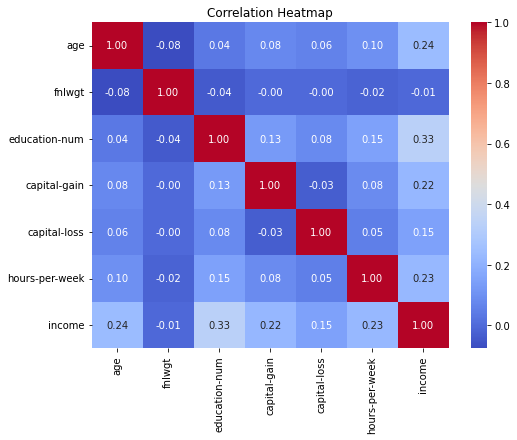

In [87]:
# Create a heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(df[numerical].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


No strong correlation between income and any features is found

In [88]:
from sklearn.metrics import mutual_info_score

In [89]:
#mutual info score
def calculate_mi(series):
    return mutual_info_score(series, df.income)

df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head())
display(df_mi.tail())

,MI
income,0.559899
relationship,0.113970
marital-status,0.108433
education,0.063673
occupation,0.063263


,MI
occupation,0.063263
sex,0.025695
workclass,0.011766
native-country,0.006149
race,0.005637


## Preparing the Train and Test datasets

In [90]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.income.values
y_val = df_val.income.values
y_test = df_test.income.values

del df_train['income']
del df_val['income']
del df_test['income']

In [91]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [189]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

### Model 1 - Logistic regression:

In [92]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [93]:
val_dict = df_val.to_dict(orient='records')


In [94]:
y_pred = model.predict_proba(X_val)[:, 1]

In [95]:
y_pred

array([0.29206261, 0.23511936, 0.33164147, ..., 0.11783187, 0.21380473,
       0.14235435])

In [98]:
(y_val == (y_pred >= 0.5)).mean()

0.7913853317811409

In [99]:
#ROC_AUC
from sklearn.metrics import roc_auc_score

In [100]:
roc_auc_score(y_val, y_pred)

0.5732198964367211

In [101]:
from sklearn.metrics import roc_curve

In [102]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

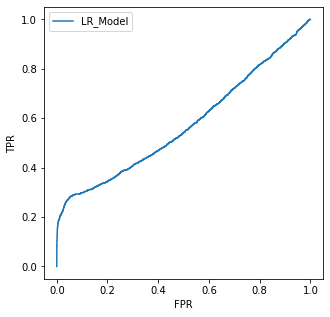

In [103]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='LR_Model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Fine Tunning thresholds for Logistic regression

1.0 0.7946449359720605


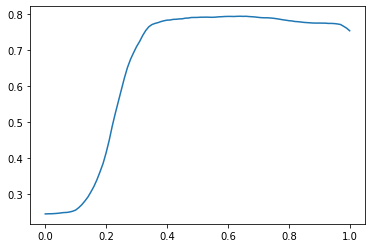

In [131]:
# Testing the best threshold
ts = np.linspace(0, 1, 101)
score_max = 0.0
threshold = 0
score = []

for t in ts:
    #score.append(t,((y_val == (y_pred >= t)).mean()))
    pred = (y_val == (y_pred >= t)).mean()
    score.append(pred)
    if pred > score_max:
        score_max = pred
        threshold = t
    
  

print(t, score_max)

plt.plot(ts, score)

In [144]:
#ts = list(ts)
df_columns = {'t':list(ts),'score':score}
df_score = pd.DataFrame(df_columns)
df_score.sort_values(by='score', ascending=False)

,t,score
64,0.64,0.794645
66,0.66,0.794529
63,0.63,0.794412
65,0.65,0.794296
61,0.61,0.794179
...,...,...
4,0.04,0.247264
3,0.03,0.246566
2,0.02,0.246100
1,0.01,0.245984


- Highest Value for threshold is 0.64, not 0.5

K-fold evaluation

In [145]:
# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [147]:
from sklearn.model_selection import KFold

In [148]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.income
    y_val = df_val.income

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.589 +- 0.010


- As we saw in other week homeworks the ROC_AUC near to 0.5 is not a good model

### Model 2 - Decision tree:

In [150]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.income.values
y_val = df_val.income.values
y_test = df_test.income.values

del df_train['income']
del df_val['income']
del df_test['income']

In [151]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [162]:
y_pred = dt.predict(X_val)
roc_auc_score(y_val, y_pred)

0.7344080949037506

Tunning the Decision Tree model

In [167]:
# checking best Max Depth
for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.753
   2 -> 0.820
   3 -> 0.845
   4 -> 0.861
   5 -> 0.877
   6 -> 0.890
   7 -> 0.895
   8 -> 0.897
   9 -> 0.897
  10 -> 0.888
  15 -> 0.839
  20 -> 0.796
None -> 0.739


- Max depth = 8 and 9 have the Best Score, so I'll use it

In [169]:
#Checking num of leafs
for m in [8, 9]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()

depth: 8
1 -> 0.897
5 -> 0.898
10 -> 0.898
15 -> 0.897
20 -> 0.898
50 -> 0.899
100 -> 0.898
200 -> 0.897

depth: 9
1 -> 0.896
5 -> 0.896
10 -> 0.896
15 -> 0.896
20 -> 0.898
50 -> 0.900
100 -> 0.901
200 -> 0.899



- The best parameter observed are Max_depth = 9 and min_samples_leaf= 100

In [187]:
#Computing Final RMSE
dt = DecisionTreeRegressor(max_depth=9, min_samples_leaf=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
auc_dt = roc_auc_score(y_val, y_pred)
rmse_dt = np.sqrt(mean_squared_error(y_val, y_pred))
print(auc_dt,rmse_dt)

0.9007635963372537 0.3216663654809512


### Model 3 - Random Forest

In [170]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.income.values
y_val = df_val.income.values
y_test = df_test.income.values

del df_train['income']
del df_val['income']
del df_test['income']

In [171]:
rf = RandomForestRegressor(n_estimators=9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
roc_auc_score(y_val, y_pred)

0.870988641682757

Tunning the Random Forest Regressor

In [188]:
#Number of estimators
aucs = []

for i in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=i, n_jobs=-1, warm_start=True, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

  0%|          | 0/20 [00:00<?, ?it/s]

10 -> 0.876
20 -> 0.887
30 -> 0.892
40 -> 0.894
50 -> 0.895
60 -> 0.896
70 -> 0.895
80 -> 0.896
90 -> 0.896
100 -> 0.897
110 -> 0.897
120 -> 0.897
130 -> 0.898
140 -> 0.898
150 -> 0.898
160 -> 0.898
170 -> 0.898
180 -> 0.898
190 -> 0.898
200 -> 0.898


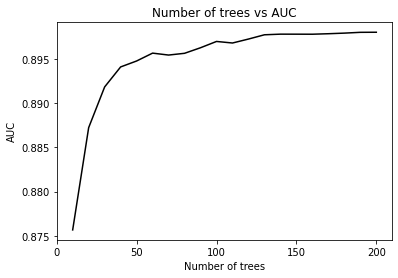

In [175]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), aucs, color='black')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

In [179]:
# Max_depth parameter
all_aucs = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []

    for i in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1, n_jobs=-1, warm_start=True)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5


  0%|          | 0/20 [00:00<?, ?it/s]

10 -> 0.891
20 -> 0.893
30 -> 0.894
40 -> 0.896
50 -> 0.896
60 -> 0.897
70 -> 0.897
80 -> 0.896
90 -> 0.897
100 -> 0.897
110 -> 0.897
120 -> 0.897
130 -> 0.897
140 -> 0.897
150 -> 0.897
160 -> 0.897
170 -> 0.898
180 -> 0.898
190 -> 0.898
200 -> 0.898

depth: 10


  0%|          | 0/20 [00:00<?, ?it/s]

10 -> 0.908
20 -> 0.910
30 -> 0.911
40 -> 0.911
50 -> 0.911
60 -> 0.911
70 -> 0.911
80 -> 0.911
90 -> 0.911
100 -> 0.912
110 -> 0.911
120 -> 0.911
130 -> 0.912
140 -> 0.912
150 -> 0.912
160 -> 0.911
170 -> 0.911
180 -> 0.912
190 -> 0.912
200 -> 0.912

depth: 20


  0%|          | 0/20 [00:00<?, ?it/s]

10 -> 0.894
20 -> 0.900
30 -> 0.902
40 -> 0.904
50 -> 0.904
60 -> 0.904
70 -> 0.904
80 -> 0.904
90 -> 0.904
100 -> 0.905
110 -> 0.905
120 -> 0.905
130 -> 0.906
140 -> 0.905
150 -> 0.906
160 -> 0.906
170 -> 0.906
180 -> 0.906
190 -> 0.906
200 -> 0.906



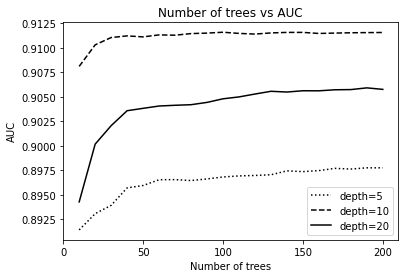

In [180]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

In [182]:
all_aucs = {}

for m in [3, 5, 10, 50, 100, 200]:
    print('min_samples_leaf: %s' % m)
    aucs = []

    for i in tqdm(range(140, 201, 20)):
        rf = RandomForestRegressor(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1, n_jobs=-1, warm_start=True)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.912
160 -> 0.911
180 -> 0.912
200 -> 0.912

min_samples_leaf: 5


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.911
160 -> 0.911
180 -> 0.911
200 -> 0.911

min_samples_leaf: 10


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.910
160 -> 0.910
180 -> 0.910
200 -> 0.910

min_samples_leaf: 50


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.908
160 -> 0.908
180 -> 0.908
200 -> 0.908

min_samples_leaf: 100


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.906
160 -> 0.906
180 -> 0.906
200 -> 0.906

min_samples_leaf: 200


  0%|          | 0/4 [00:00<?, ?it/s]

140 -> 0.902
160 -> 0.902
180 -> 0.902
200 -> 0.902



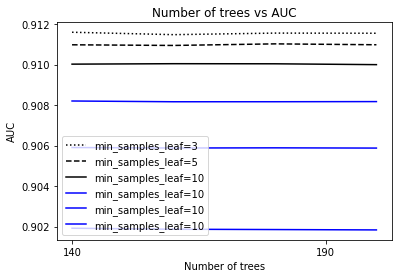

In [184]:
plt.figure(figsize=(6, 4))

num_trees = list(range(140, 201, 20))

plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
plt.plot(num_trees, all_aucs[50], label='min_samples_leaf=10', color='blue', linestyle='solid')
plt.plot(num_trees, all_aucs[100], label='min_samples_leaf=10', color='blue', linestyle='solid')
plt.plot(num_trees, all_aucs[200], label='min_samples_leaf=10', color='blue', linestyle='solid')
    
plt.xticks(range(140, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

- The best parameters observed are n_estimators=200, max_depth=10, min_samples_leaf=3

In [186]:
#Computing Final RMSE
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
auc_rf = roc_auc_score(y_val, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred))
print(auc_rf,rmse_rf)

0.9115507796501082 0.31396362798122335


In [ ]:
# #Computing Final RMSE

# y_pred = rf.predict(X_test)
# auc_rf_test = roc_auc_score(y_test, y_pred)
# rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(auc_rf_test,rmse_rf_test)

## The best model is Random Forest Regressor with best AUC_Score and lower RMSE